In [1]:
# !pip install opencv-python
# !pip install scikit-image
# !pip install scikit-learn

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

2025-03-15 12:21:31.960768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 12:21:31.960838: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 12:21:31.960883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 12:21:31.976734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define paths
main_dir = './CVDATASET'
train_dataset_dir = os.path.join(main_dir, "train")
test_dataset_dir = os.path.join(main_dir, "test")

In [25]:
first_five_real_paths = [os.path.join(train_dataset_dir, "REAL") + "/" + K for K in os.listdir(os.path.join(train_dataset_dir, "REAL"))[:5] ]
first_five_fake_paths = [os.path.join(train_dataset_dir, "FAKE") + "/" + K for K in os.listdir(os.path.join(train_dataset_dir, "FAKE"))[:5] ]
first_five_fake_paths

['./CVDATASET/train/FAKE/5999.jpg',
 './CVDATASET/train/FAKE/5999 (9).jpg',
 './CVDATASET/train/FAKE/5999 (8).jpg',
 './CVDATASET/train/FAKE/5999 (7).jpg',
 './CVDATASET/train/FAKE/5999 (6).jpg']

In [21]:
train_dataset_dir

'./CVDATASET/train'

In [4]:
#==================================================================================================================================
# Define image dimensions and batch size
img_height = 32
img_width = 32
batch_size = 64

# Load the training data
train_ds_full = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Split train into train and validation
train_size = int(0.8 * len(train_ds_full))
val_size = len(train_ds_full) - train_size
train_ds = train_ds_full.take(train_size)
val_ds = train_ds_full.skip(train_size)

# Load the test data
val_ds_test = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Training Classes:")
class_names = train_ds_full.class_names
print(class_names)

print("Testing Classes:")
print(val_ds_test.class_names)

Found 100000 files belonging to 2 classes.


2025-03-15 12:22:06.748863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:08.0, compute capability: 8.0
2025-03-15 12:22:06.750652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:09.0, compute capability: 8.0
2025-03-15 12:22:07.915625: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


# 1. Class Balance Bar Graph

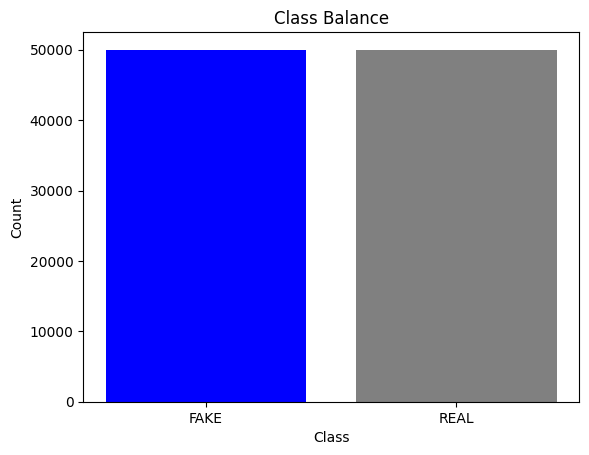

In [20]:
class_counts = {cls: 0 for cls in class_names}
for images, labels in train_ds_full:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'grey'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

# 2. Display sample images

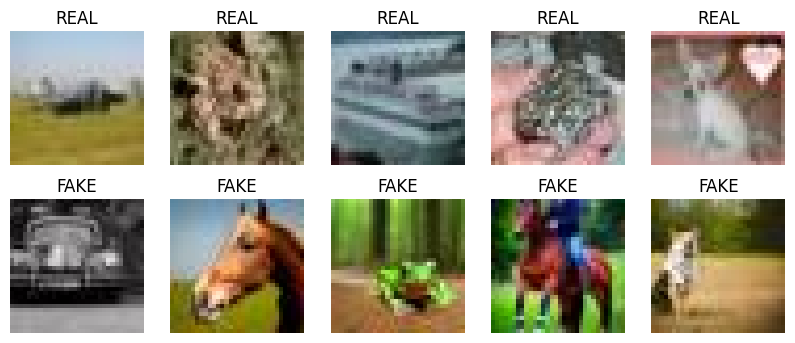

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
sample_count = {"REAL": 0, "FAKE": 0}

for images, labels in train_ds_full:
    for i in range(len(images)):
        class_label = class_names[labels[i].numpy()]
        if sample_count[class_label] < 5:
            row = 0 if class_label == "REAL" else 1
            col = sample_count[class_label]
            axes[row, col].imshow(images[i].numpy().astype("uint8"))
            axes[row, col].axis("off")
            axes[row, col].set_title(class_label)
            sample_count[class_label] += 1
        if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
            break
    if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
        break

plt.show()

# 3. Clustering with EfficientNet embeddings

In [7]:
# Function to extract embeddings from an EfficientNetV2S model
def get_efficientnet_embeddings(dataset):
    model = EfficientNetV2S(weights='imagenet', include_top=False, pooling='avg')
    embeddings, labels = [], []
    for images, lbls in dataset:
        features = model.predict(images)
        embeddings.extend(features)
        labels.extend(lbls.numpy())
    return np.array(embeddings), np.array(labels)

# Compute embeddings and cluster
X_eff, y_true = get_efficientnet_embeddings(train_ds_full)
kmeans = KMeans(n_clusters=len(class_names), random_state=42).fit(X_eff)
y_pred = kmeans.labels_
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)


82420632/82420632 [==============================] - 1s 0us/step


2025-03-15 12:22:48.819779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-03-15 12:22:48.886960: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 52ms/step
EfficientNet Clustering ARI: 0.0033, NMI: 0.0024


In [11]:
print(f"EfficientNet Clustering ARI: {ari:.4f}, NMI: {nmi:.4f}")

EfficientNet Clustering ARI: 0.0033, NMI: 0.0024


# 4. HOG Feature Extraction

In [12]:
def get_hog_features(dataset):
    hog_features, labels = [], []
    for images, lbls in dataset:
        for img in images.numpy():
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
            hog_features.append(features)
        labels.extend(lbls.numpy())
    return np.array(hog_features), np.array(labels)

X_hog, y_true = get_hog_features(train_ds_full)
kmeans = KMeans(n_clusters=len(class_names), random_state=42).fit(X_hog)
y_pred = kmeans.labels_
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)
print(f"HOG Clustering ARI: {ari:.4f}, NMI: {nmi:.4f}")

HOG Clustering ARI: 0.0446, NMI: 0.0348


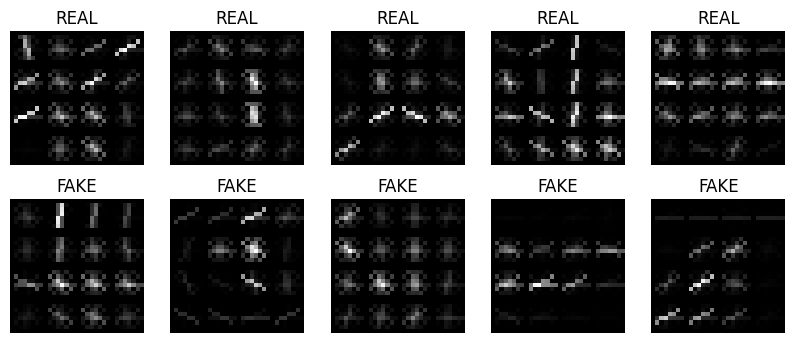

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
hog_sample_count = {"REAL": 0, "FAKE": 0}

for images, labels in train_ds_full:
    for i in range(len(images)):
        class_label = class_names[labels[i].numpy()]
        if hog_sample_count[class_label] < 5:
            row = 0 if class_label == "REAL" else 1
            col = hog_sample_count[class_label]
            gray = cv2.cvtColor(images[i].numpy(), cv2.COLOR_RGB2GRAY)
            _, hog_img = hog(gray, visualize=True)
            axes[row, col].imshow(hog_img, cmap='gray')
            axes[row, col].axis("off")
            axes[row, col].set_title(class_label)
            hog_sample_count[class_label] += 1
        if hog_sample_count["REAL"] == 5 and hog_sample_count["FAKE"] == 5:
            break
    if hog_sample_count["REAL"] == 5 and hog_sample_count["FAKE"] == 5:
        break

plt.show()

# 5. Canny Edge Detection

In [18]:
def get_canny_features(dataset):
    canny_features, labels = [], []
    for images, lbls in dataset:
        for img in images.numpy():
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            gray = cv2.convertScaleAbs(gray)  # Ensure valid depth for Canny
            edges = cv2.Canny(gray, 100, 200)
            canny_features.append(edges.flatten())
        labels.extend(lbls.numpy())
    return np.array(canny_features), np.array(labels)

X_canny, y_true = get_canny_features(train_ds_full)
kmeans = KMeans(n_clusters=len(class_names), random_state=42).fit(X_canny)
y_pred = kmeans.labels_
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)
print(f"Canny Clustering ARI: {ari:.4f}, NMI: {nmi:.4f}")

Canny Clustering ARI: 0.0273, NMI: 0.0198


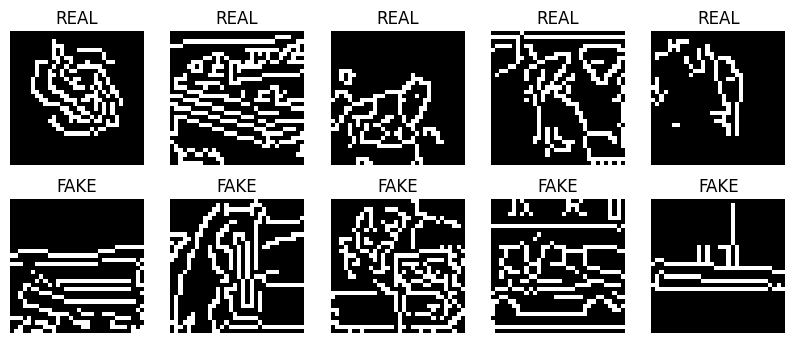

In [27]:
# Display Canny Edge images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

sample_count = {"REAL": 0, "FAKE": 0}

for images, labels in train_ds_full:
    for i in range(len(images)):
        class_label = class_names[labels[i].numpy()]
        if sample_count[class_label] < 5:
            row = 0 if class_label == "REAL" else 1
            col = sample_count[class_label]
            gray = cv2.cvtColor(images[i].numpy(), cv2.COLOR_RGB2GRAY)
            gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  # Normalize image
            edges = cv2.Canny(gray, 100, 200)
            axes[row, col].imshow(edges, cmap='gray')
            axes[row, col].axis("off")
            axes[row, col].set_title(class_label)
            sample_count[class_label] += 1
        if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
            break
    if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
        break

plt.show()


# 6. Display Sobel Filter images

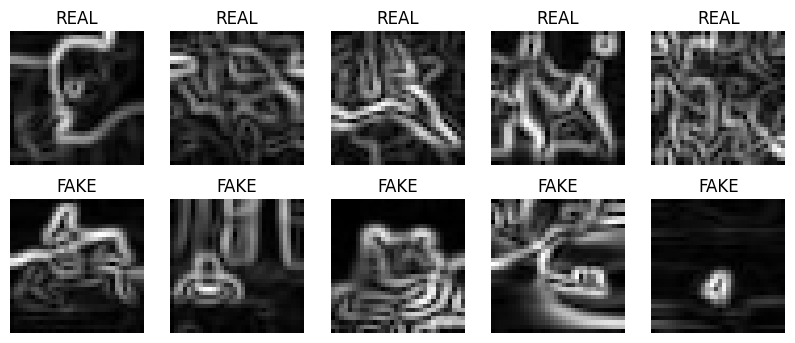

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

sample_count = {"REAL": 0, "FAKE": 0}

for images, labels in train_ds_full:
    for i in range(len(images)):
        class_label = class_names[labels[i].numpy()]
        if sample_count[class_label] < 5:
            row = 0 if class_label == "REAL" else 1
            col = sample_count[class_label]
            
            # Convert image to grayscale
            gray = cv2.cvtColor(images[i].numpy(), cv2.COLOR_RGB2GRAY)
            
            # Apply Sobel filter
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # X-direction
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # Y-direction
            sobel = cv2.magnitude(sobelx, sobely)  # Compute magnitude
            
            # Normalize and convert to uint8
            sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            
            # Display the Sobel-filtered image
            axes[row, col].imshow(sobel, cmap='gray')
            axes[row, col].axis("off")
            axes[row, col].set_title(class_label)
            sample_count[class_label] += 1

        if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
            break
    if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
        break

plt.show()

# 7. Display Ben Graham Filtered images

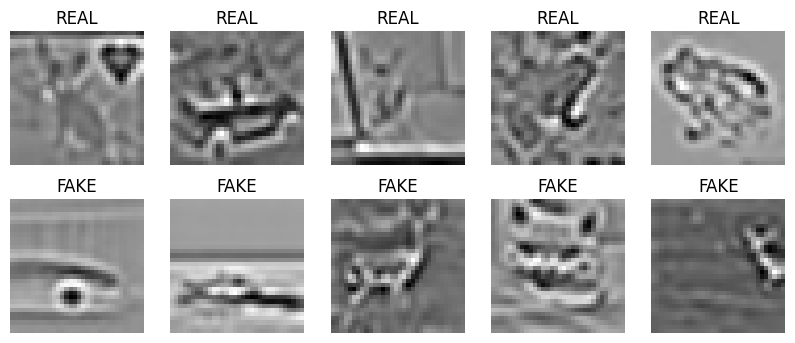

In [30]:
# Display Ben Graham Filtered images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

sample_count = {"REAL": 0, "FAKE": 0}

for images, labels in train_ds_full:
    for i in range(len(images)):
        class_label = class_names[labels[i].numpy()]
        if sample_count[class_label] < 5:
            row = 0 if class_label == "REAL" else 1
            col = sample_count[class_label]

            # Convert image to grayscale and ensure float32 type
            gray = cv2.cvtColor(images[i].numpy(), cv2.COLOR_RGB2GRAY).astype(np.float32)

            # Apply Gaussian Blur
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            # Apply Laplacian filter
            ben_graham = cv2.Laplacian(blurred, cv2.CV_32F)

            # Normalize and convert to uint8
            ben_graham = cv2.normalize(ben_graham, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            # Display the Ben Graham processed image
            axes[row, col].imshow(ben_graham, cmap='gray')
            axes[row, col].axis("off")
            axes[row, col].set_title(class_label)
            sample_count[class_label] += 1

        if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
            break
    if sample_count["REAL"] == 5 and sample_count["FAKE"] == 5:
        break

plt.show()
